In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
import nltk
from wordcloud import WordCloud
import string
from functools import reduce
from nltk.stem import WordNetLemmatizer
import tqdm

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
lemmatizer = WordNetLemmatizer()

def clear_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))


def get_stopwords_remover(stop_words):
    return lambda words: words[~words.isin(stop_words)]


def lemmatize(words):
    return words.apply(lemmatizer.lemmatize)


def preprocessing_pipeline(steps):
    return lambda raw_text: reduce(lambda data, func: func(data), steps, raw_text)


def lowercase(words):
    return words.str.lower()

In [3]:
with open('data/doyle.txt') as file:
    doyle = file.read()
with open('data/doyle-2.txt') as file:
    doyle += file.read()

with open('data/poe.txt') as file:
    poe = file.read()
with open('data/poe-2.txt') as file:
    poe += file.read()

In [4]:
stop_words = set(stopwords.words('english'))
remove_stopwords = get_stopwords_remover(stop_words)
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [5]:
pipe = preprocessing_pipeline([
    clear_punctuation,
    word_tokenize,
    pd.Series,
    lowercase,
    remove_stopwords,
    lemmatize
])

In [6]:
doyle_words: pd.Series = pipe(doyle)
poe_words: pd.Series = pipe(poe)

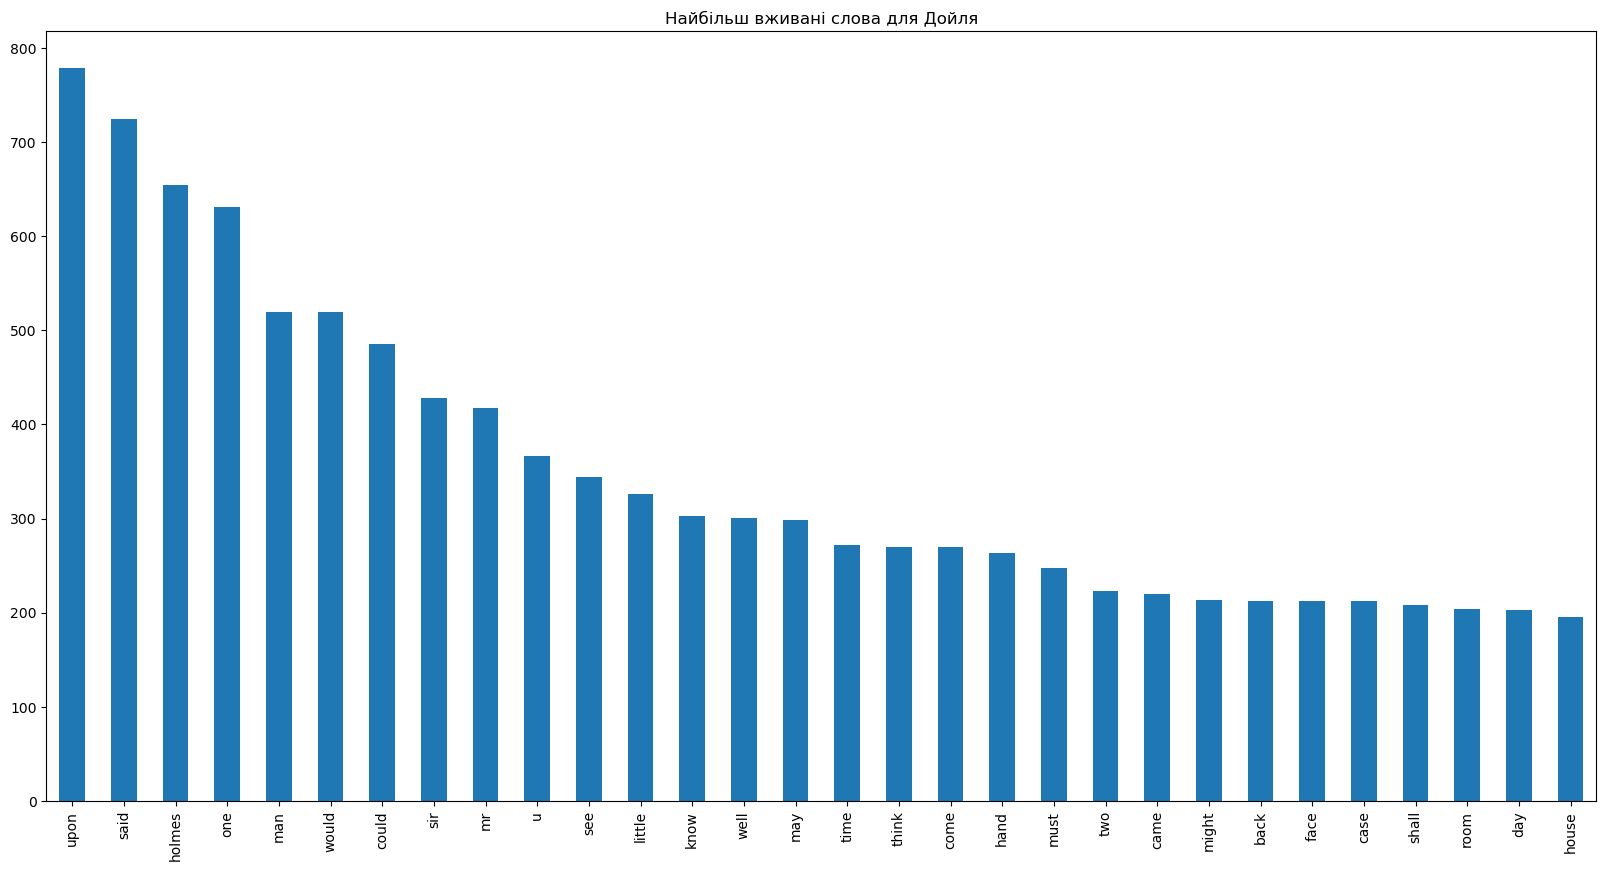

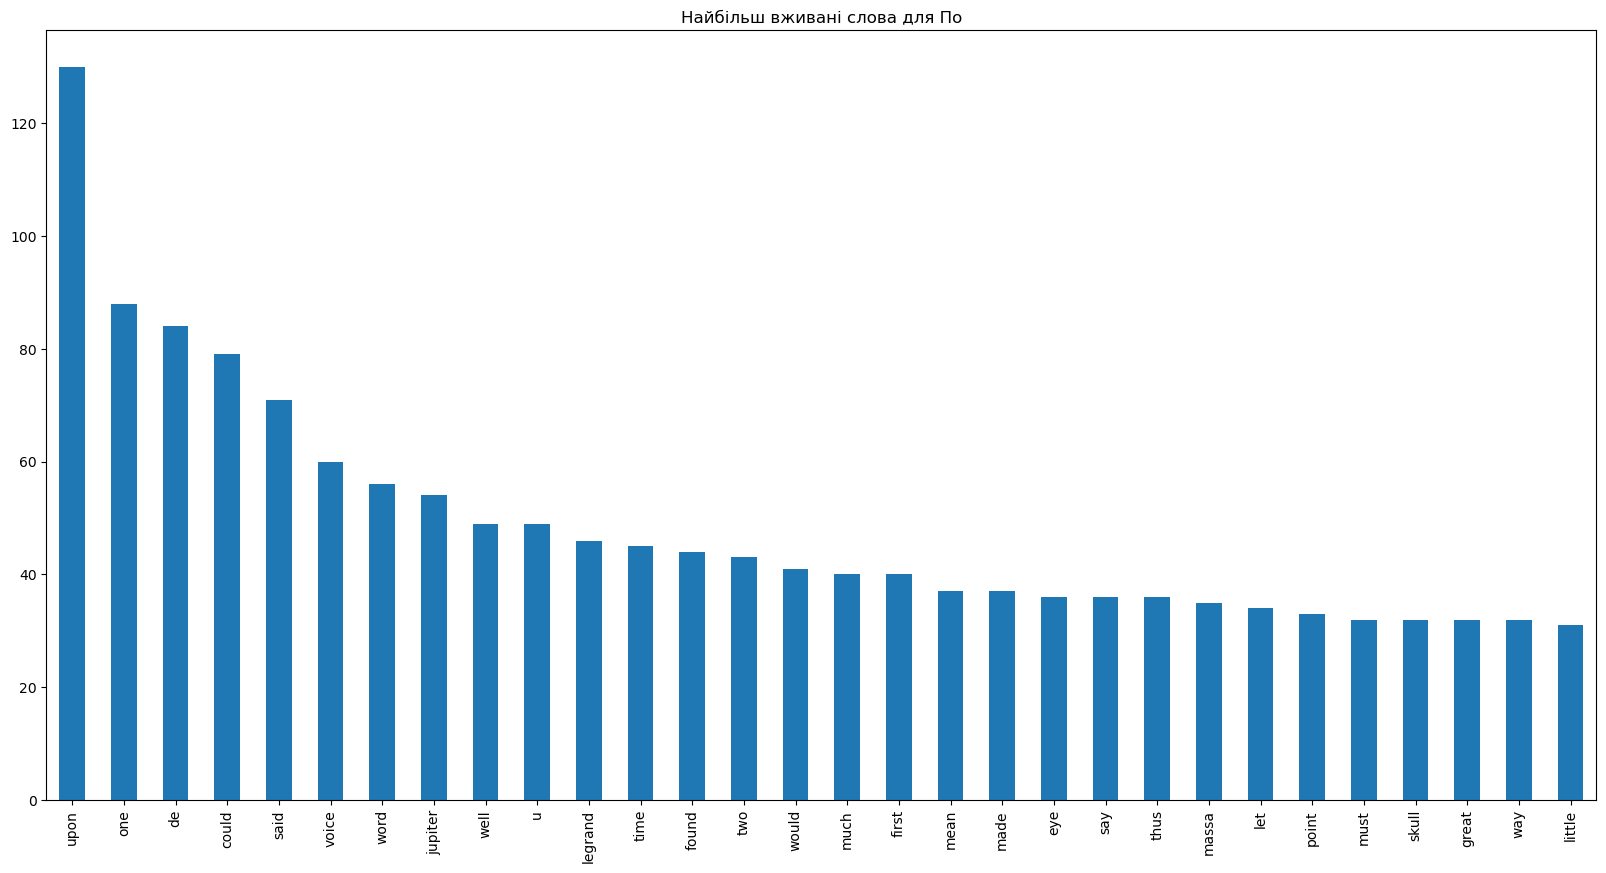

In [7]:
n = 30
plt.figure(figsize=(20, 10))
plt.title('Найбільш вживані слова для Дойля')
doyle_words.value_counts().head(n).plot.bar()

plt.figure(figsize=(20, 10))
plt.title('Найбільш вживані слова для По')
poe_words.value_counts().head(n).plot.bar();

In [8]:
custom_stopwords = {'upon', 'could', 'would', 'us', 'u', 'man', 'mr', 'de', 'may', 'must', 'thus', 'say', 'much', 'two', }
remove_custom_stopwords = get_stopwords_remover(custom_stopwords)

In [9]:
doyle_words = remove_custom_stopwords(doyle_words)
poe_words = remove_custom_stopwords(poe_words)

In [10]:
doyle_words = pd.Series(doyle_words)
poe_words = pd.Series(poe_words)

In [11]:
wordcloud = WordCloud(
    background_color='white',
    width=1000, height=1000
)

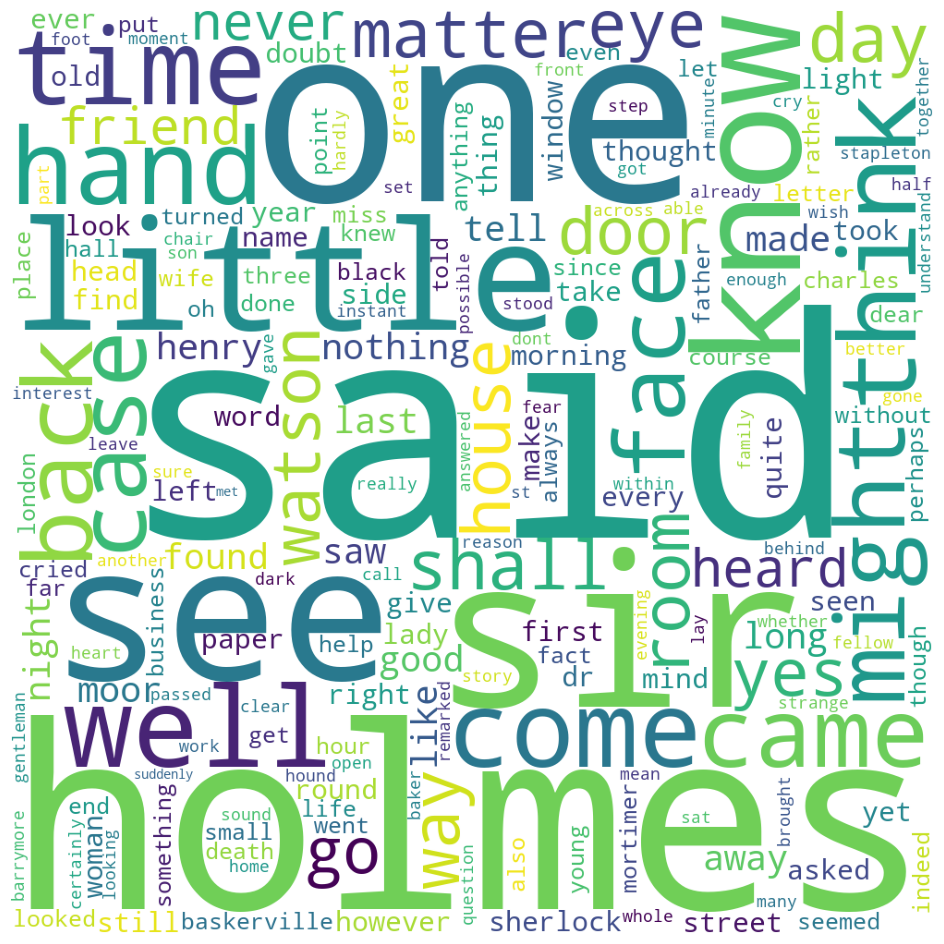

In [12]:
doyle_cloud = wordcloud.generate_from_frequencies(doyle_words.value_counts())

plt.figure(figsize=(12, 12))
plt.imshow(doyle_cloud)
plt.axis(False);

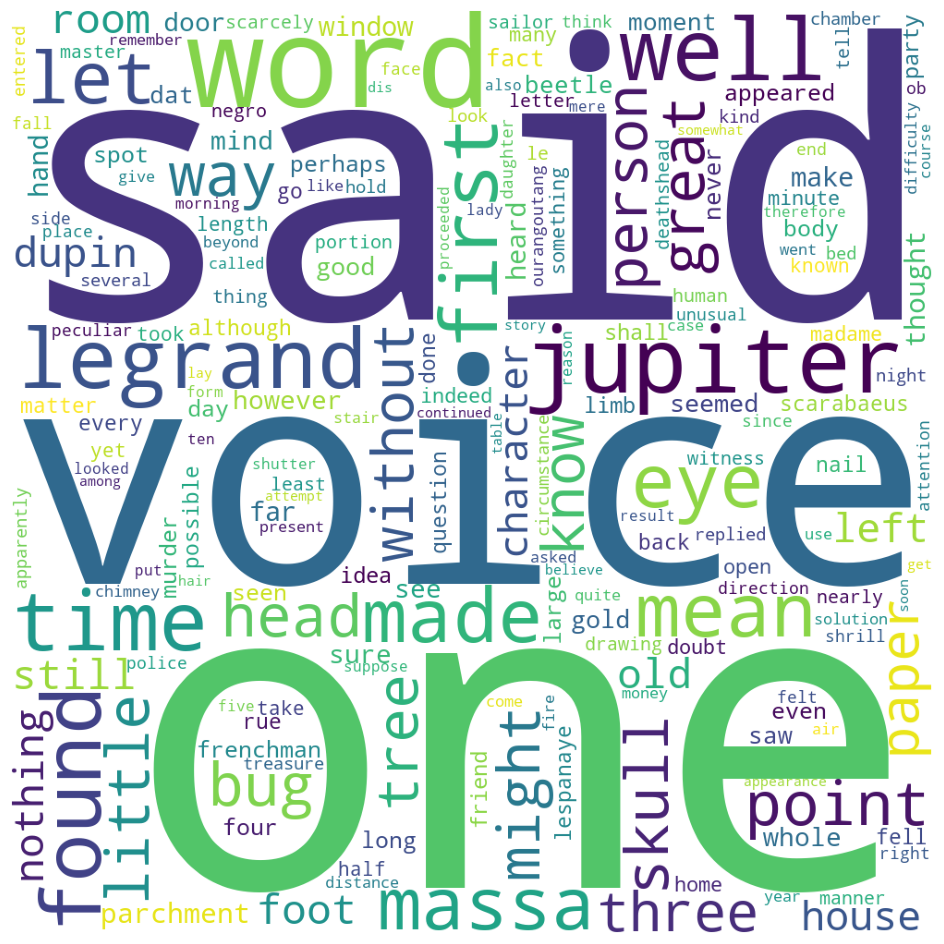

In [13]:
poe_cloud = wordcloud.generate_from_frequencies(poe_words.value_counts())

plt.figure(figsize=(12, 12))
plt.imshow(poe_cloud)
plt.axis(False);

In [14]:
def get_wordnet_pos(w: str) -> str:
    treebank_tag = nltk.pos_tag([w])[0][1]
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [15]:
doyle_score = 0
poe_score = 0
doyle_count = 0
poe_count = 0

for word, count in tqdm.tqdm(list(doyle_words.value_counts().items())):
    synsets = list(swn.senti_synsets(word, get_wordnet_pos(word)))
    if synsets:
        score = synsets[0].pos_score() - synsets[0].neg_score()
        doyle_score += score * count
        doyle_count += count

for word, count in tqdm.tqdm(list(poe_words.value_counts().items())):
    synsets = list(swn.senti_synsets(word, get_wordnet_pos(word)))
    if synsets:
        score = synsets[0].pos_score() - synsets[0].neg_score()
        poe_score += score * count
        poe_count += count

doyle_score /= len(doyle_words)
poe_score /= len(poe_words)

print(f'Doyle score: {doyle_score}, Poe score: {poe_score}')

100%|██████████| 3910/3910 [00:02<00:00, 1381.84it/s]

Doyle score: 0.0028967595648804567, Poe score: 0.002898256992298338


In [16]:
print('По писав більш похмурі оповідання' if poe_score < doyle_score else 'Дойль писав більш похмурі оповідання')

Дойль писав більш похмурі оповідання
